# Time Series Prototyping for Intrusion Detection 

In [178]:
# use print only as a function
from __future__ import print_function
import sys
sys.version_info

sys.version_info(major=3, minor=5, micro=1, releaselevel='final', serial=0)

## Connect to data and read into dataframe

In [203]:
__author__ = 'swe03'

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from decimal import *

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from scipy import stats

import statsmodels.api as sm
import statsmodels.tsa as tsa

from statsmodels.graphics.api import qqplot
from statsmodels.tsa.base import datetools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime

desired_width = 250
pd.set_option('display.width',desired_width)

In [4]:
# Read in the csv file stored in Data folder in Network Security 
data_sample = pd.read_csv("H:\\Network Security/Data/ExtraHop/message_test_1k.csv ")
data_sample.head(5)
#print('\n Data Type')
#data_sample.dtypes
#type(data_sample)


,id,ts,event_type_id,location,host,service,attributes_senderAddr,attributes_senderPort,attributes_receiverAddr,attributes_receiverPort,attributes_pkts,attributes_bytes,attributes_first,attributes_last,attributes_tcpFlags,attributes_l7proto,attributes_proto,attributes_tos
0,SO43ZMJ74FIU7JPRDSWAGY2BG472HASZVM2A5LPOU62RVU...,1469751859551,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,35688,172.26.160.15,4080,1,60,1469751828222,1469751828259,16,tcp:4080,TCP,0
1,LLIJNAAJFQBZAA2PODUZDYGP3CUC3QW5FKZLD6IZSJLL2Q...,1469209811339,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,172.26.160.11,11103,151.140.3.131,9997,16,8513,1469209780518,1469209811208,25,tcp:9997,TCP,0
2,HP25PVDWMQA2PAO3LAPDZKJSX44LYZBDE3VS4RAM2BP3DD...,1469203717557,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,17419,172.26.160.15,4081,1,60,1469203690019,1469203690049,16,tcp:17419,TCP,0
3,WMXFUSNYI5723IGPKO3SLOYDPPZRRGV65D77K3YYJEXRNS...,1469261073539,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,22760,172.26.160.14,4081,1,60,1469261049894,1469261049917,16,tcp:22760,TCP,0
4,VDASJL3X2PKQLWUITFGS7BI3VJUCU3KZKKKARO4WYXMQHK...,1469731130712,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,26990,172.26.160.21,80,2,120,1469731108263,1469731108263,16,tcp:80,TCP,0


###### Install the SQL package if not already installed 

In [5]:
!pip install pandasql  

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
# Convert the ts variable to a number of date-time values for Time Series index
# Use the functions usec_to_timestamp

from pandasql import PandaSQL 
pdsql = PandaSQL()
#type(pdsql)
#local = locals()

today = datetime.date.today()
print today
print 'ctime:', today.ctime()
print 'tuple:', today.timetuple()
print 'ordinal:', today.toordinal()
print 'Year:', today.year
print 'Mon :', today.month
print 'Day :', today.day

In [7]:
#df = (data_sample.ts[0]) # gets the first element of the series and the type is int64
#type(data_sample.ts)    # this is a series

#df = pd.datetime.fromtimestamp(data_sample['ts'])  #cannot convert the series to <class 'float'>
#df

In [8]:
#df = datetime.fromtimestamp(data_sample['ts'].astype(str) )     # TypeError: cannot convert the series to <class 'float'>
#df

#df = datetime.fromtimestamp(data_sample.ts[0]/1000)            # ....but this works
#df                    #datetime.datetime(2016, 7, 28, 20, 24, 19, 551000)

In [ ]:
ds = pd.to_datetime(data_sample['ts'], unit='ms' ) # This works but df is a Series. Need to convert to DF. Note that the
                                                   # series name is ds but the ts variable name is retained for the DF
df1 = pd.DataFrame.from_dict(ds)   # Converted to DataFrame.  Column name is ts
data_sample['datetime1'] = ' '  # Create the new variable
data_sample['datetime1'] = df1['ts']  #Populate the new variable with the ts column from the new dataframe df1
pd.to_datetime(data_sample['datetime1'])   # this works and displays the correct dtype: datetime64[ns]
data_sample['hour'] = ' '                  # do the same to create an hour variable
data_sample['hour'] = df1.ts.dt.hour 

data_sample['date_hour'] = data_sample.datetime1.dt.strftime('%Y-%m-%d-%H')  # This works and creates a Series with Date and Hour
data_sample['date_hour'] = pd.to_datetime(data_sample['date_hour'] )

#df2['hour'] = df1.ts.dt.hour          # the ts attribute here is the variable in df1.

#df = pd.DataFrame.from_dict(ds.dt.hour)   # This will create another DF with the df series populating the ts column

#### This was key for the SQL division below where the Entropy measure starts to be developed

In [204]:
data_sample['attributes_bytes'] = data_sample['attributes_bytes'].astype(float)


#dir(ds)    # get all the attributes
#dir(ds.dt) # get the Date / Time attributes
#ds.dt.month    # display just the Month from the Series
#ds.dt.hour     # display just the Hour from the Series 
#ds              # display the full date time value
#df['datetime']
#df1
data_sample
#dir(data_sample)
#type(data_sample.attributes_bytes[0])  ## numpy.float64
#data_sample.attributes_bytes[0]         ## displays with the decimal point (e.g., 60.0)
#date_hour
#dir(data_sample.datetime1.dt)
#data_sample.datetime1.dt.hour

,id,ts,event_type_id,location,host,service,attributes_senderAddr,attributes_senderPort,attributes_receiverAddr,attributes_receiverPort,...,attributes_bytes,attributes_first,attributes_last,attributes_tcpFlags,attributes_l7proto,attributes_proto,attributes_tos,datetime1,hour,date_hour
2016-07-29 00:00:00,SO43ZMJ74FIU7JPRDSWAGY2BG472HASZVM2A5LPOU62RVU...,1469751859551,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,35688,172.26.160.15,4080,...,60,1469751828222,1469751828259,16,tcp:4080,TCP,0,2016-07-29 00:24:19.551,0,2016-07-29 00:00:00
2016-07-22 17:00:00,LLIJNAAJFQBZAA2PODUZDYGP3CUC3QW5FKZLD6IZSJLL2Q...,1469209811339,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,172.26.160.11,11103,151.140.3.131,9997,...,8513,1469209780518,1469209811208,25,tcp:9997,TCP,0,2016-07-22 17:50:11.339,17,2016-07-22 17:00:00
2016-07-22 16:00:00,HP25PVDWMQA2PAO3LAPDZKJSX44LYZBDE3VS4RAM2BP3DD...,1469203717557,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,17419,172.26.160.15,4081,...,60,1469203690019,1469203690049,16,tcp:17419,TCP,0,2016-07-22 16:08:37.557,16,2016-07-22 16:00:00
2016-07-23 08:00:00,WMXFUSNYI5723IGPKO3SLOYDPPZRRGV65D77K3YYJEXRNS...,1469261073539,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,22760,172.26.160.14,4081,...,60,1469261049894,1469261049917,16,tcp:22760,TCP,0,2016-07-23 08:04:33.539,8,2016-07-23 08:00:00
2016-07-28 18:00:00,VDASJL3X2PKQLWUITFGS7BI3VJUCU3KZKKKARO4WYXMQHK...,1469731130712,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,26990,172.26.160.21,80,...,120,1469731108263,1469731108263,16,tcp:80,TCP,0,2016-07-28 18:38:50.712,18,2016-07-28 18:00:00
2016-07-22 20:00:00,F4V53SNZC53CPUB5GNB3UJ3OG7OUAMVIPVA5UW3GI72A76...,1469220615703,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,172.26.160.10,63630,151.140.3.131,9997,...,6694,1469220555176,1469220615701,25,tcp:9997,TCP,0,2016-07-22 20:50:15.703,20,2016-07-22 20:00:00
2016-07-22 14:00:00,FWCAIAWWZQSHHOIE6L5PJMSLRTNADZ2S27BHLI64SLW5SM...,1469198971553,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,64890,172.26.160.15,4080,...,0,1469198954467,0,0,tcp:4080,TCP,0,2016-07-22 14:49:31.553,14,2016-07-22 14:00:00
2016-07-23 07:00:00,QHPWP6DIWT7RPVI4YZHE3YW7FQUTCE55KQI4D4426VCJMG...,1469257889491,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,172.26.160.11,37211,151.140.3.131,9997,...,198,1469257888774,1469257889491,17,tcp:9997,TCP,0,2016-07-23 07:11:29.491,7,2016-07-23 07:00:00
2016-07-22 19:00:00,6AY3GEFL3VAULSDT63IGHURP274OCPJJYUF3ZIXXIVJIXW...,1469215730537,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,172.26.160.18,443,172.29.237.82,13291,...,120,1469215712903,1469215712903,17,tcp:443,TCP,0,2016-07-22 19:28:50.537,19,2016-07-22 19:00:00
2016-07-28 14:00:00,KPOIO53TYSRN4YQLVONBYIACFUZKRH3R3P3BBTPJV6OSGN...,1469717379537,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,42276,172.26.160.15,4080,...,120,1469717348575,1469717348577,16,tcp:4080,TCP,0,2016-07-28 14:49:39.537,14,2016-07-28 14:00:00


In [205]:
#type(data_sample.srv_count)  # the type is Series
#type(data_sample.datetime)  # the type is Series

data_sample = data_sample.set_index(pd.DatetimeIndex(data_sample['date_hour']))

print(data_sample.index)                   # works and confirms the existence of the index as a DateTime object
#data_sample.index                         # same 
#data_sample
#pd.to_datetime(data_sample['datetime'])   # this works and displays the correct dtype: datetime64[ns]
#print(data_sample.dtypes)                 # only shows datatime col as an "object"
#type(data_sample['datetime'])              # this indicates that the type is pandas.core.series.Series, if the col is there. 
                                           # if datetime is an index only then the "type" function will fail
#datetools._is_datetime_index(data_sample)  # although a "datetime" value is in the index, a 0 return value from this function
                                           # indicates it is not a datetime value. However, this creates an error of KeyError:0


DatetimeIndex(['2016-07-29 00:00:00', '2016-07-22 17:00:00', '2016-07-22 16:00:00', '2016-07-23 08:00:00', '2016-07-28 18:00:00', '2016-07-22 20:00:00', '2016-07-22 14:00:00', '2016-07-23 07:00:00', '2016-07-22 19:00:00', '2016-07-28 14:00:00',
               ...
               '2016-07-28 22:00:00', '2016-07-28 12:00:00', '2016-07-28 14:00:00', '2016-07-28 20:00:00', '2016-07-22 23:00:00', '2016-07-23 08:00:00', '2016-07-22 17:00:00', '2016-07-22 22:00:00', '2016-07-22 18:00:00', '2016-07-28 13:00:00'],
              dtype='datetime64[ns]', length=1000, freq=None)


##### Execute some Univariate Statistics

In [206]:
data_sample['attributes_bytes'].describe()

count      1000.000000
mean        945.020000
std        7463.660391
min           0.000000
25%          60.000000
50%         120.000000
75%         120.000000
max      119104.000000
Name: attributes_bytes, dtype: float64

In [207]:
import matplotlib.pyplot as pplt

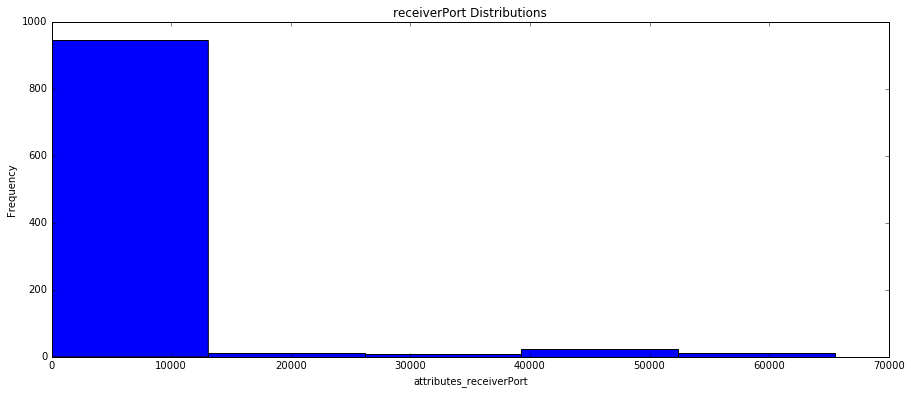

In [208]:
fig=pplt.figure()
ax = fig.add_subplot(1,1,1)  #Create one or more subplots using add_subplot, because you can't create blank figure

ax.hist(data_sample['attributes_receiverPort'],bins = 5)   #Variable
 
pplt.title('receiverPort Distributions')
pplt.xlabel('attributes_receiverPort')
pplt.ylabel('Frequency')
pplt.show()

In [209]:
# This is for the full data set
test= data_sample.groupby([data_sample.datetime1.dt.hour,'attributes_receiverPort'])   # or use the hour variable created above
test.size()

datetime1  attributes_receiverPort
0          0                           1
           80                          5
           4080                       15
           4081                        9
           7745                        1
           9997                        3
           45449                       1
           49716                       1
           52434                       1
1          80                         10
           4080                        8
           4081                       11
           65478                       1
2          0                           1
           80                          3
           4080                       10
           4081                       10
           9887                        1
           9997                        1
3          80                          3
           4080                       10
           4081                       16
           9997                        2
           14005      

In [210]:
subset_list = ['4080','4081']   # Not used below but needs to be validated
ds2 = data_sample[data_sample.attributes_receiverPort == 4080]
ds2

,id,ts,event_type_id,location,host,service,attributes_senderAddr,attributes_senderPort,attributes_receiverAddr,attributes_receiverPort,...,attributes_bytes,attributes_first,attributes_last,attributes_tcpFlags,attributes_l7proto,attributes_proto,attributes_tos,datetime1,hour,date_hour
2016-07-29 00:00:00,SO43ZMJ74FIU7JPRDSWAGY2BG472HASZVM2A5LPOU62RVU...,1469751859551,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,35688,172.26.160.15,4080,...,60,1469751828222,1469751828259,16,tcp:4080,TCP,0,2016-07-29 00:24:19.551,0,2016-07-29 00:00:00
2016-07-22 14:00:00,FWCAIAWWZQSHHOIE6L5PJMSLRTNADZ2S27BHLI64SLW5SM...,1469198971553,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,64890,172.26.160.15,4080,...,0,1469198954467,0,0,tcp:4080,TCP,0,2016-07-22 14:49:31.553,14,2016-07-22 14:00:00
2016-07-28 14:00:00,KPOIO53TYSRN4YQLVONBYIACFUZKRH3R3P3BBTPJV6OSGN...,1469717379537,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,42276,172.26.160.15,4080,...,120,1469717348575,1469717348577,16,tcp:4080,TCP,0,2016-07-28 14:49:39.537,14,2016-07-28 14:00:00
2016-07-28 20:00:00,WTJSNEMDP6TZJKNNYJWCUFHQP2UP45S3YWRTLI3P2KQMA2...,1469736443543,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,15790,172.26.160.14,4080,...,120,1469736423514,1469736423514,16,tcp:15790,TCP,0,2016-07-28 20:07:23.543,20,2016-07-28 20:00:00
2016-07-23 04:00:00,SWDOVQXGMFUG6KGUJ4H5ZNG6AFUFZIA4HZINAN6Y4CW2RT...,1469248643537,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,6536,172.26.160.14,4080,...,60,1469248619104,1469248619132,16,tcp:6536,TCP,0,2016-07-23 04:37:23.537,4,2016-07-23 04:00:00
2016-07-22 13:00:00,4LW5Y5GG77ZREZA2QRZPURMHPCAJK4I5A5H6OQL3DSLFFW...,1469195075684,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,45548,172.26.160.15,4080,...,60,1469195043776,1469195043814,16,tcp:4080,TCP,0,2016-07-22 13:44:35.684,13,2016-07-22 13:00:00
2016-07-22 23:00:00,BVA2KUJGO4ET7SZUK3CB6ZYNWMALCNSME2UEVKPLR3PWXW...,1469230843550,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,26578,172.26.160.14,4080,...,120,1469230814273,1469230814274,16,tcp:26578,TCP,0,2016-07-22 23:40:43.550,23,2016-07-22 23:00:00
2016-07-22 18:00:00,NJ5CMGB24O2TLMETEGFOWGL3FBNL4O4OKBBSHGIXO7WGV3...,1469212523544,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,1342,172.26.160.14,4080,...,120,1469212503470,1469212503472,16,tcp:1342,TCP,0,2016-07-22 18:35:23.544,18,2016-07-22 18:00:00
2016-07-23 04:00:00,IH5WUEJ2PKVVQCBE5PNWTO6ITP2EU3QEYHDZ6BGN2PQDO5...,1469247163542,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,39762,172.26.160.15,4080,...,120,1469247147283,1469247147286,16,tcp:4080,TCP,0,2016-07-23 04:12:43.542,4,2016-07-23 04:00:00
2016-07-22 20:00:00,D5TJ57OL7CR3MW4YWSKILWK2CPGY4KAVG55RMUKCVOPZHE...,1469220395550,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,45346,172.26.160.14,4080,...,120,1469220370964,1469220370966,16,tcp:4080,TCP,0,2016-07-22 20:46:35.550,20,2016-07-22 20:00:00


In [256]:
#df_s1 = pdsql("""SELECT * from ds2 where hour = 10 """,locals())  ## This works but not with the date_hour
#df_s1
#type(ds2.date_hour[0])

audit = ds2[ds2['date_hour']=="2016-07-22 13:00:00"]
audit

,id,ts,event_type_id,location,host,service,attributes_senderAddr,attributes_senderPort,attributes_receiverAddr,attributes_receiverPort,...,attributes_bytes,attributes_first,attributes_last,attributes_tcpFlags,attributes_l7proto,attributes_proto,attributes_tos,datetime1,hour,date_hour
2016-07-22 13:00:00,4LW5Y5GG77ZREZA2QRZPURMHPCAJK4I5A5H6OQL3DSLFFW...,1469195075684,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,45548,172.26.160.15,4080,...,60,1469195043776,1469195043814,16,tcp:4080,TCP,0,2016-07-22 13:44:35.684,13,2016-07-22 13:00:00
2016-07-22 13:00:00,4FVAX2JPNQS6W56YJKZOUC7D3FBZDPQT7YWNVI2Y3B4ETB...,1469194879545,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,37769,172.26.160.15,4080,...,120,1469194849422,1469194849424,16,tcp:4080,TCP,0,2016-07-22 13:41:19.545,13,2016-07-22 13:00:00
2016-07-22 13:00:00,I6G3NGWULCKO2F7UMQ7XLH3MCD4UKM7NANXOGPGU37PLCY...,1469193879563,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,57447,172.26.160.15,4080,...,60,1469193860889,1469193860926,16,tcp:4080,TCP,0,2016-07-22 13:24:39.563,13,2016-07-22 13:00:00
2016-07-22 13:00:00,AVJLSVJQQ5MYJSBEQUHITWE62NA7ZAVHPFE4WBCOAFP43C...,1469193735555,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,58863,172.26.160.15,4080,...,60,1469193714044,1469193714079,16,tcp:4080,TCP,0,2016-07-22 13:22:15.555,13,2016-07-22 13:00:00
2016-07-22 13:00:00,MGNHAL3WGPHNRNFS5FDZ76IBLFSHOYW3HOTPRODNJDTQHE...,1469195863556,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,53811,172.26.160.14,4080,...,0,1469195831975,0,0,tcp:4080,TCP,0,2016-07-22 13:57:43.556,13,2016-07-22 13:00:00
2016-07-22 13:00:00,7EHQE42ILELJBEKO2GFJCVIIMLDHQRWLC2NMZPM5QPUQQF...,1469195531543,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,3490,172.26.160.15,4080,...,60,1469195499626,1469195499661,16,tcp:3490,TCP,0,2016-07-22 13:52:11.543,13,2016-07-22 13:00:00
2016-07-22 13:00:00,2QNLKN33S7FUJ7ZQNBY5G36XQXZBJXOM6LXCKI2KXEPNB5...,1469195739556,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,35822,172.26.160.15,4080,...,120,1469195723210,1469195723212,16,tcp:4080,TCP,0,2016-07-22 13:55:39.556,13,2016-07-22 13:00:00
2016-07-22 13:00:00,OL4PP4ZP3PP4GVIHZPTY6O5V3FAHSWDDOMKNMLOWSCJUI2...,1469193663542,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.12,61689,172.26.160.15,4080,...,120,1469193633307,1469193633309,16,tcp:4080,TCP,0,2016-07-22 13:21:03.542,13,2016-07-22 13:00:00
2016-07-22 13:00:00,MWT2A53HODN66LZ5QKCNWUJWMN23MR77CZEUF6WT3SNVM5...,1469193647701,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,24953,172.26.160.14,4080,...,60,1469193615824,1469193615860,16,tcp:24953,TCP,0,2016-07-22 13:20:47.701,13,2016-07-22 13:00:00
2016-07-22 13:00:00,B3YE4GN4RTYAQDWQKRIX7O7GC627YWOAHUAYXNBUUDQBD2...,1469193687557,230010,AUS/PR,aus-prod-eh01.homedepot.com,ExtraHop,192.168.1.4,13839,172.26.160.15,4080,...,60,1469193658354,1469193658387,16,tcp:13839,TCP,0,2016-07-22 13:21:27.557,13,2016-07-22 13:00:00


In [212]:
# This is for the filtered data set
test= ds2.groupby([ds2.datetime1.dt.hour,'attributes_receiverPort'])   # or use the hour variable created above
test.size()

datetime1  attributes_receiverPort
0          4080                       15
1          4080                        8
2          4080                       10
3          4080                       10
4          4080                        7
5          4080                        2
6          4080                        4
7          4080                        4
8          4080                        4
9          4080                        3
10         4080                        1
11         4080                       11
12         4080                        3
13         4080                       30
14         4080                       31
15         4080                       21
16         4080                       20
17         4080                       16
18         4080                       23
19         4080                       15
20         4080                       22
21         4080                       22
22         4080                       24
23         4080       

In [213]:
port_df = ds2[['date_hour','attributes_bytes']]    # Single brackets return a Series while 
                                                                             # double brackets return a DataFrame
port_df.head() 
print(type(port_df.attributes_bytes[0])) 
#port_df

<class 'numpy.float64'>


In [214]:
# convert ints to floats
#float(port_df.attributes_bytes[0])  # this works and casts correctly but then the print below displays an integer
#dir(port_df.attributes_bytes)
#pd.to_numeric(port_df.attributes_bytes)
type(port_df.attributes_bytes)  ## Series
print(port_df.attributes_bytes[0])
#print(type(port_df.attributes_bytes[0])) 
#print(type(port_df.attributes_bytes[1])) 

60.0


In [52]:
#port_df_group = port_df.groupby('date_hour')
#port_df_group.size()

In [258]:
#port_df_totals = port_df_group.sum()  # This will sum all variables
#port_df_sum = port_df.groupby(port_df['date_hour']).sum() 
#port_df_sum 
#dir(port_df.groupby(port_df['date_hour']))
#port_df_mean = port_df.groupby(port_df['date_hour']).mean() 
port_df_mean 
#port_df_median = port_df.groupby(port_df['date_hour']).median() 
#port_df_median
#port_df_quantile = port_df.groupby(port_df['date_hour']).quantile([.25,.50,.75]) 
#port_df_quantile


,attributes_bytes
date_hour,
2016-07-22 13:00:00,76.363636
2016-07-22 14:00:00,67.826087
2016-07-22 15:00:00,85.000000
2016-07-22 16:00:00,78.947368
2016-07-22 17:00:00,78.461538
2016-07-22 18:00:00,90.000000
2016-07-22 19:00:00,90.000000
2016-07-22 20:00:00,93.750000
2016-07-22 21:00:00,86.250000


In [219]:
calc1 = pdsql("""select i.date_hour, i.attributes_bytes from ds2 i""",locals())
print(calc1) # 324 rows
#print("ds value",type(ds2.attributes_bytes[0]))
#calc2 = pdsql("""select s.date_hour, s.attributes_bytes from port_df_sum s""",locals())
#print(calc2)  # 40 rows
#print("port value",type(port_df_sum.attributes_bytes[0]))

                      date_hour  attributes_bytes
0    2016-07-29 00:00:00.000000                60
1    2016-07-22 14:00:00.000000                 0
2    2016-07-28 14:00:00.000000               120
3    2016-07-28 20:00:00.000000               120
4    2016-07-23 04:00:00.000000                60
5    2016-07-22 13:00:00.000000                60
6    2016-07-22 23:00:00.000000               120
7    2016-07-22 18:00:00.000000               120
8    2016-07-23 04:00:00.000000               120
9    2016-07-22 20:00:00.000000               120
10   2016-07-22 23:00:00.000000               120
11   2016-07-22 17:00:00.000000                60
12   2016-07-22 15:00:00.000000                60
13   2016-07-22 17:00:00.000000                 0
14   2016-07-28 20:00:00.000000                60
15   2016-07-22 18:00:00.000000               120
16   2016-07-22 21:00:00.000000                60
17   2016-07-22 13:00:00.000000               120
18   2016-07-28 11:00:00.000000                60


In [229]:
#calc_ent1 = pdsql("""SELECT cast((i.attributes_bytes / s.attributes_bytes) as float) as ent1 
#                  from ds2 i join port_df_sum s
#                  on i.date_hour = s.date_hour """,locals())
calc_ent1 = pdsql("""SELECT i.date_hour, (i.attributes_bytes / s.attributes_bytes) as ent1 
                  from ds2 i join port_df_sum s
                  on i.date_hour = s.date_hour 
                  order by i.date_hour""",locals())
print(calc_ent1)

#print(calc_ent1.ent1[2])  ## will display decimal value from first pdsql above but not correct since the div first creates a zero
#type(calc_ent1.ent1[0])  ## float is displayed from first pdsql above
#type(calc_ent1['ent1'])   ## series

                      date_hour      ent1
0    2016-07-22 13:00:00.000000  0.035714
1    2016-07-22 13:00:00.000000  0.071429
2    2016-07-22 13:00:00.000000  0.035714
3    2016-07-22 13:00:00.000000  0.035714
4    2016-07-22 13:00:00.000000  0.000000
5    2016-07-22 13:00:00.000000  0.035714
6    2016-07-22 13:00:00.000000  0.071429
7    2016-07-22 13:00:00.000000  0.071429
8    2016-07-22 13:00:00.000000  0.035714
9    2016-07-22 13:00:00.000000  0.035714
10   2016-07-22 13:00:00.000000  0.035714
11   2016-07-22 13:00:00.000000  0.035714
12   2016-07-22 13:00:00.000000  0.035714
13   2016-07-22 13:00:00.000000  0.071429
14   2016-07-22 13:00:00.000000  0.071429
15   2016-07-22 13:00:00.000000  0.035714
16   2016-07-22 13:00:00.000000  0.035714
17   2016-07-22 13:00:00.000000  0.071429
18   2016-07-22 13:00:00.000000  0.071429
19   2016-07-22 13:00:00.000000  0.071429
20   2016-07-22 13:00:00.000000  0.035714
21   2016-07-22 13:00:00.000000  0.000000
22   2016-07-22 14:00:00.000000  0

In [230]:
calc_ent1['ln_ent1'] = np.log(calc_ent1['ent1'])
calc_ent1

,date_hour,ent1,ln_ent1
0,2016-07-22 13:00:00.000000,0.035714,-3.332205
1,2016-07-22 13:00:00.000000,0.071429,-2.639057
2,2016-07-22 13:00:00.000000,0.035714,-3.332205
3,2016-07-22 13:00:00.000000,0.035714,-3.332205
4,2016-07-22 13:00:00.000000,0.000000,-inf
5,2016-07-22 13:00:00.000000,0.035714,-3.332205
6,2016-07-22 13:00:00.000000,0.071429,-2.639057
7,2016-07-22 13:00:00.000000,0.071429,-2.639057
8,2016-07-22 13:00:00.000000,0.035714,-3.332205
9,2016-07-22 13:00:00.000000,0.035714,-3.332205


In [243]:
# The first value has been audited and validated
calc_ent2 = pdsql("""SELECT i.date_hour, sum(i.ent1 * i.ln_ent1) as hx_ent,  count(i.date_hour) as hour_event_cnt
                  from calc_ent1 i
                  group by i.date_hour
                  order by i.date_hour""",locals())
#calc_ent2

In [257]:
calc_ent2['entropy'] = -(calc_ent2['hx_ent'] / np.log(calc_ent2['hour_event_cnt']))
calc_ent2

,date_hour,hx_ent,hour_event_cnt,entropy
0,2016-07-22 13:00:00.000000,-2.936120,22,0.949880
1,2016-07-22 14:00:00.000000,-2.884863,23,0.920067
2,2016-07-22 15:00:00.000000,-2.425480,12,0.976085
3,2016-07-22 16:00:00.000000,-2.886165,19,0.980209
4,2016-07-22 17:00:00.000000,-2.425480,13,0.945625
5,2016-07-22 18:00:00.000000,-2.833739,18,0.980406
6,2016-07-22 19:00:00.000000,-2.351257,12,0.946216
7,2016-07-22 20:00:00.000000,-2.719810,16,0.980964
8,2016-07-22 21:00:00.000000,-2.713579,16,0.978717
9,2016-07-22 22:00:00.000000,-2.889263,19,0.981261


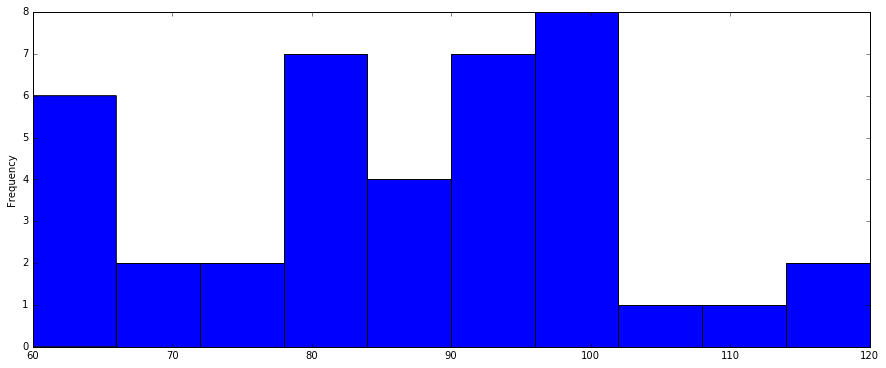

In [260]:
## Frequency of attributes_bytes ranges (can't yet figure out how to make bins rather than accepting default)
#dir(port_df.plot.hist)
#my_plot = port_df_totals['attributes_bytes'].plot.hist()
my_plot = port_df_mean['attributes_bytes'].plot.hist()

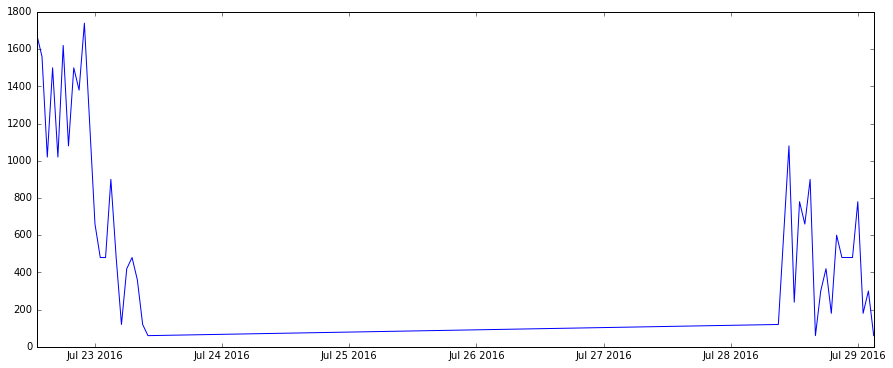

In [101]:
my_plot=pplt.plot(port_df_totals['attributes_bytes'])
pplt.autoscale(enable=True, axis='x', tight=None)
pplt.show()

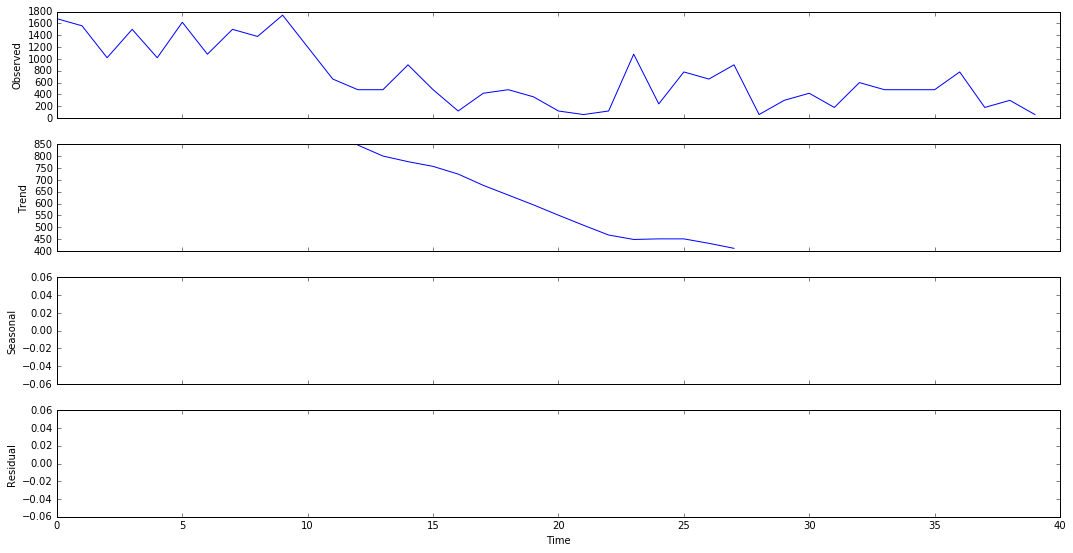

In [105]:
decomposition = seasonal_decompose(port_df_totals.attributes_bytes.values, freq=24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [57]:
model=ARIMA(data_sample['srv_count'],(1,0,0))    ## The endogenous variable needs to be type Float or you get a cast error
model_fit = model.fit()       # fit is a Function
model_fcst = model_fit.fittedvalues    # fittedvalues is a Series
#print(model_fit.summary())
print(model_fcst)

2016-09-11 00:00:00     7.614100
2016-09-11 01:00:00     4.903360
2016-09-11 02:00:00     4.903360
2016-09-11 03:00:00     9.001786
2016-09-11 04:00:00     6.952573
2016-09-11 05:00:00    11.050999
2016-09-11 06:00:00    15.149424
2016-09-11 07:00:00     5.313203
2016-09-11 08:00:00     8.182101
2016-09-11 09:00:00     4.903360
2016-09-11 10:00:00     5.313203
2016-09-11 11:00:00     5.313203
2016-09-11 12:00:00     5.313203
2016-09-11 13:00:00     4.903360
2016-09-11 14:00:00     5.313203
2016-09-11 15:00:00     5.313203
2016-09-11 16:00:00     5.313203
2016-09-11 17:00:00     4.903360
2016-09-11 18:00:00     4.903360
2016-09-11 19:00:00     6.542731
2016-09-11 20:00:00    10.641156
2016-09-11 21:00:00     6.542731
2016-09-11 22:00:00     6.952573
2016-09-11 23:00:00     9.821471
2016-09-12 00:00:00    13.919897
2016-09-12 01:00:00     4.903360
2016-09-12 02:00:00     4.903360
2016-09-12 03:00:00     4.903360
2016-09-12 04:00:00     5.313203
2016-09-12 05:00:00     5.313203
          

In [58]:
from pprint import pprint               # get a variety of different attributes from the object (including functions)
#pprint (dir(model))
#pprint (dir(model_fit))

In [59]:
print(model.endog_names)
print(model.exog_names)
print(model.information)
print(model.predict)

srv_count
['const', 'ar.L1.srv_count']
<bound method LikelihoodModel.information of <statsmodels.tsa.arima_model.ARMA object at 0x000000000BEB4748>>
<bound method ARMA.predict of <statsmodels.tsa.arima_model.ARMA object at 0x000000000BEB4748>>


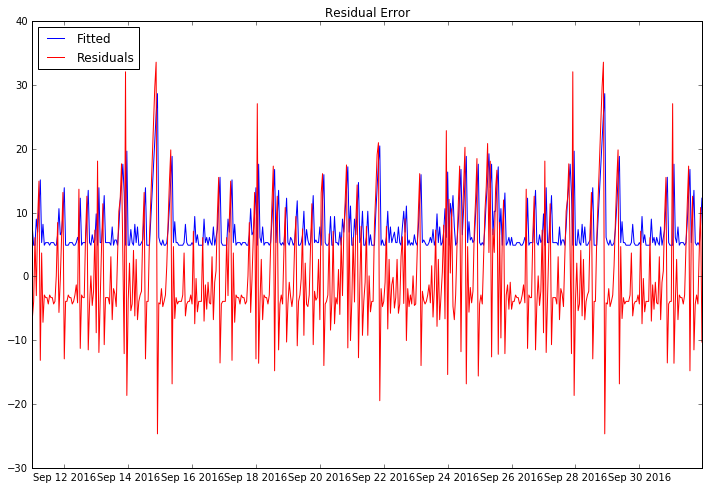

In [60]:
#print(model_fit.resid)
#print(model_fit.fittedvalues)

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(model_fit.fittedvalues, color='blue',label='Fitted')
resid = plt.plot(model_fit.resid, color='red', label='Residuals')
   
plt.legend(loc='best')
plt.title('Residual Error')
plt.show()